In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from functions.model3 import GAN
import datetime
import json
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers

2.16.2
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def shuffle_data(feature_data, real_data):
    # feature_data: numpy array
    # real_data: tf.Tensor

    # Make sure we have the same number of samples
    assert feature_data.shape[0] == real_data.shape[0], "Mismatched number of samples"

    # Generate shuffled indices
    indices = np.arange(feature_data.shape[0])
    np.random.shuffle(indices)

    # Apply to both
    feature_shuffled = feature_data[indices]
    real_shuffled = tf.gather(real_data, indices)

    return feature_shuffled, real_shuffled

In [3]:
DISCRIMINATOR_STEPS = 10
DISCRIMINATOR_LAYER_MULTIPLIER =2
GP_WEIGHT = 10
LEARNING_RATE = 1e-5
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
BATCH_SIZE = 32
EPOCHS = 5
D_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)
#G_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)

2025-09-28 20:07:58.059985: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-28 20:07:58.060019: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-28 20:07:58.060025: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-28 20:07:58.060040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-28 20:07:58.060051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load data

In [4]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

In [5]:
train_data = process_model_data(targets, features, tickers) #feature_data, target_data

print(train_data)

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d

(1003, 32) (1003, 8)
(array([[-3.11450883, -3.12851254, -3.10222685, ...,  0.62003834,
         0.60053185, -0.10861688],
       [-3.11404847, -3.10628977, -3.10037093, ...,  0.62468468,
         0.60160637, -0.10782955],
       [-3.07912399, -3.09051469, -3.06700327, ...,  0.71580919,
         0.62353948, -0.09228374],
       ...,
       [ 0.00732872, -0.02709264,  0.02707568, ...,  1.63523456,
         1.23619644,  0.96422604],
       [-0.04632254,  0.03623137,  0.01911607, ...,  1.7822867 ,
         1.37784571,  1.01190215],
       [-0.02684475, -0.03390184, -0.01272491, ...,  1.8861846 ,
         1.51519262,  1.05536491]]), <tf.Tensor: shape=(1003, 8), dtype=float32, numpy=
array([[-0.13254122, -0.348768  , -0.6622379 , ..., -0.84551233,
        -0.3418808 , -0.0632446 ],
       [-0.09881812, -0.18353522, -1.0892333 , ..., -0.5975361 ,
        -0.288783  ,  0.5028163 ],
       [-0.20412464, -0.59402144, -0.9434304 , ..., -1.2999794 ,
        -0.6810397 , -0.6372123 ],
       ...,
 

## Load generator from Qiskit

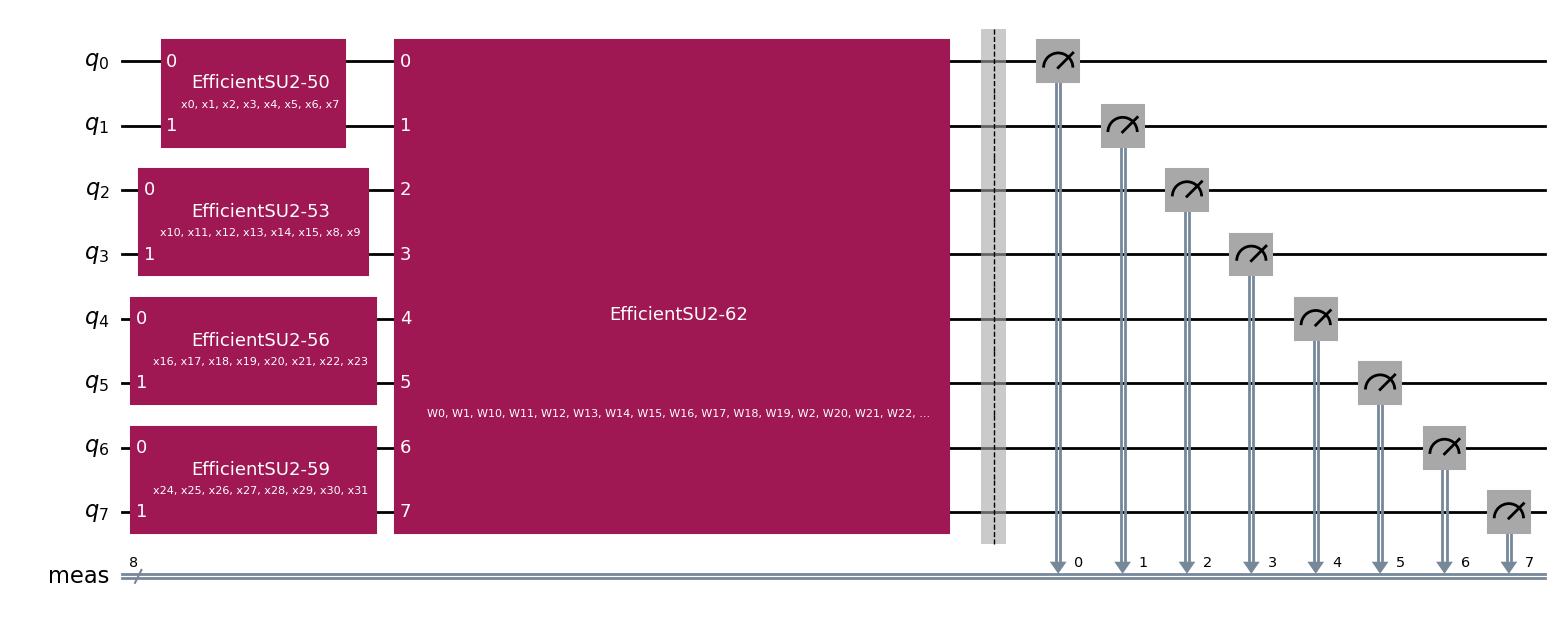

In [6]:
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

In [7]:
qgan = GAN(
    discriminator_steps= DISCRIMINATOR_STEPS,
    gp_weight= GP_WEIGHT,
    n_tickers= len(tickers),
    n_features= len(features),
    n_outputs= len(targets),
    generator_qiskit=qc,
    discriminator_layer_multiplier=DISCRIMINATOR_LAYER_MULTIPLIER,
    on_hardware= False,
    batch_size= BATCH_SIZE,
)

qgan.compile(
    d_optimizer = D_OPTIMIZER,
    
)

/Users/a01milner/Documents/Schro-horse/.venv/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
/Users/a01milner/Documents/Schro-horse/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
#os.mkdir("models/")
time = datetime.datetime.now().strftime("%d%m.%H%M")
model_path = f"models/models_{time}"
os.mkdir(model_path)

In [9]:
import os
import numpy as np
import json
from tensorflow.keras.callbacks import Callback

class SaveWeightsAndMetrics(Callback):
    def __init__(self, qgan, save_dir="checkpoints", save_weights=True, save_metrics=True):
        super().__init__()
        self.qgan = qgan   # <-- store GAN object here
        self.save_dir = save_dir
        self.save_weights = save_weights
        self.save_metrics = save_metrics
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save generator weights
        if self.save_weights:
            weights_path = os.path.join(self.save_dir, f"generator_weights_epoch{epoch+1}.npy")
            weights_list = [w.numpy() for w in self.qgan.generator_weights]
            np.save(weights_path, weights_list)
            print(f"✅ Saved generator weights to {weights_path}")

        # Save metrics
        if self.save_metrics:
            metrics_path = os.path.join(self.save_dir, f"metrics_epoch{epoch+1}.json")
            with open(metrics_path, "w") as f:
                json.dump({k: float(v) for k, v in logs.items()}, f, indent=2)
            print(f"📊 Saved metrics to {metrics_path}")


In [10]:
callbacks = [
    SaveWeightsAndMetrics(qgan=qgan, save_dir=f"{model_path}/logs")
]

In [11]:
feature_data, real_data = train_data
feature_data, real_data = shuffle_data(feature_data,real_data)

In [12]:
qgan.fit(
    feature_data=feature_data.astype(np.float32),
    real_data=real_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/5 - {'d_loss': 8.98409914970398, 'g_loss': -0.051696381997317076, 'd_gp': 0.8978828992694616, 'd_wass_loss': 0.005270165403999272, 'real_score': 0.04642621602397412, 'gen_score': 0.051696381997317076}
✅ Saved generator weights to models/models_2809.2008/logs/generator_weights_epoch1.npy
📊 Saved metrics to models/models_2809.2008/logs/metrics_epoch1.json
Epoch 2/5 - {'d_loss': 8.345320016145706, 'g_loss': -0.04797004454303533, 'd_gp': 0.8346657268702984, 'd_wass_loss': -0.0013372140856517944, 'real_score': 0.0493072597309947, 'gen_score': 0.04797004454303533}
✅ Saved generator weights to models/models_2809.2008/logs/generator_weights_epoch2.npy
📊 Saved metrics to models/models_2809.2008/logs/metrics_epoch2.json
Epoch 3/5 - {'d_loss': 7.502649217844009, 'g_loss': -0.004226790068059927, 'd_gp': 0.753945991396904, 'd_wass_loss': -0.03681126603623852, 'real_score': 0.0410380563698709, 'gen_score': 0.004226790068059927}
✅ Saved generator weights to models/models_2809.2008/logs/genera

In [13]:
qgan.generator_save(f"{model_path}/generator.npy") 
qgan.discriminator.save(f"{model_path}/discriminator.keras")

Generator weights saved to models/models_2809.2008/generator.npy
